# Loading the data

In [421]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

TITANIC_FOLDER_PATH = path = os.path.join("datasets", "titanic")


def load_titanic_data(filename):
    file_path = os.path.join(TITANIC_FOLDER_PATH, filename)
    return pd.read_csv(file_path)

In [422]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
gender_submission_data = load_titanic_data("gender_submission.csv")

In [423]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Ok, we have the data. The test set does not have a label. That's meant to run your model on it and make the submissions and see the result.

# Explore the data

In [424]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Does the dataset have empty values?

In [425]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [426]:
train_data.isna().sum() / len(train_data)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

There are empty values. Almost 20% of age, 77% of Cabin and 0.02 % of Embarked. Let's check closer.

In [427]:
train_data["Age"].value_counts()


24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

In [428]:
train_data["Cabin"].value_counts()


B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Cabin seems to be a categorical value. Doesn't help a lot since there are a lot of values. But what if we just keep the cabin number? Like A, B, C, D ? Maybe we could engineer that feature.

In [429]:
train_data["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Same thing for Ticket. A categorical value with a lot of values. Not very helpful at first sight.

In [430]:
train_data["Embarked"].value_counts()


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Just 3 categories here representing 3 different embarking locations. The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

## Even before exploring the data more let's train a classifier and see the result we get
We'll train a model by applying just a simple transformation. Filling in empty values with the median for numerical columns and scaling them. For categorical values we'll fill in the missing values with the most frequest since median can't work and encoding them using a one hot encoder.

We won't use all the columns for the training since some are useless for us at the moment before we learn more and we do some feature engineering. Here's what we'll drop:
* **PassengerId**: does not contain any info
* **Survived**: that's the target that we're predicting so no need for it
* **Name**: Not good info at the moment, name should not affect survival rate. But maybe it does, we should check
* **Ticket**: Too many values to treat as a category, so we'll drop it
* **Cabin**: Too many values to treat as a category, so we'll drop it

We'll keep the rest of them though and pass through a pipeline transformer

In [431]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder()),
])

from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])


In [432]:
cleaned_training_data = train_data[num_attribs + cat_attribs]
cleaned_training_data

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,22.0,1,0,7.2500,3,male,S
1,38.0,1,0,71.2833,1,female,C
2,26.0,0,0,7.9250,3,female,S
3,35.0,1,0,53.1000,1,female,S
4,35.0,0,0,8.0500,3,male,S
...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,2,male,S
887,19.0,0,0,30.0000,1,female,S
888,NaN,1,2,23.4500,3,female,S
889,26.0,0,0,30.0000,1,male,C


Let's transform the training data

In [433]:
X_train = preprocess_pipeline.fit_transform(cleaned_training_data)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Looks good. Let's train a classifier for this. Let's keep the labels in a different variable before.

In [434]:
y_train = train_data["Survived"]
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [435]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

How about a different model? Like an SVC

In [436]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

Over 80% accuracy on the validation set using both models. That's not bad at all. And we did this before doing any meaningful exploration and feature engineering.
* Are the features we used relevant? What if we don't need all
* Do the features we dropped contain relevant information? Can we adjust and use them?
* Is the model good? We should try a few more
* We should fine-tune the hyperparameters as well

# Let's explore the data in more depth

In [437]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)


Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


## Let's check how many passengers survived

In [438]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [439]:
train_data["Survived"].value_counts(normalize=True)


0    0.616162
1    0.383838
Name: Survived, dtype: float64

I'll create a method to plot different dataframes based on survival since i'll need this later.

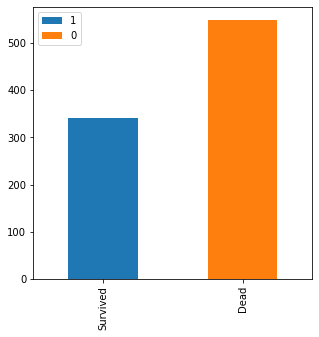

In [440]:
def survival_chart_stacked(data, feature, stacked=True):
    survived = data[data["Survived"] == 1][feature].value_counts()
    dead = data[data["Survived"] == 0][feature].value_counts()
    survived_dead = pd.DataFrame([survived, dead])
    survived_dead.index = ["Survived", "Dead"]
    survived_dead.plot(kind="bar", stacked=stacked, figsize=(5, 5))


survival_chart_stacked(train_data, "Survived")

So yea, 38% only survived. The data set suffers from imbalance but this imbalance is important, so we shouldn't sample it.

## Is the likelihood of survival dependent on gender?

In [441]:
train_data["Sex"].value_counts()


male      577
female    314
Name: Sex, dtype: int64

In [442]:
train_data["Sex"].value_counts(normalize=True)


male      0.647587
female    0.352413
Name: Sex, dtype: float64

In [443]:
train_data.groupby("Sex")["Survived"].mean()


Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

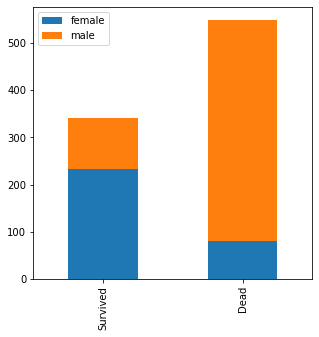

In [444]:
survival_chart_stacked(train_data, "Sex")


It's clear here that the majority of people who survived were women. 4 times higher that the survival rate for men. It confirms that they  applied the women and children first.

## Is the likelihood of survival dependent on class?

In [445]:
train_data["Pclass"].value_counts(normalize=True)

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [446]:
train_data.groupby("Pclass")["Survived"].mean()


Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

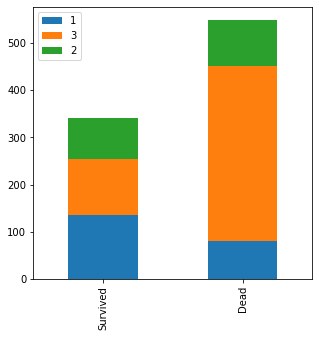

In [447]:
survival_chart_stacked(train_data, "Pclass")


The class seems to be relevant. Most of the passengers (55%) had class 3 tickets but only 24% of them survived. 63% of class 1 survived which is very relevant and 47% of class 2.
We should explore if the higher survival rate in class 1 is due to the actual class and not another reason.

## Is the higher survival rate in Class 1 due to the class itself or due to a skewed gender distribution in which female passengers dominate?

In [448]:
train_data.groupby(["Pclass", "Sex"])["Survived"].mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

In [449]:
train_data.groupby(["Pclass"])["Sex"].value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

We can see that no, there's not a horrible bias in numbers towards women in class 1. So let's check the survival rate grouping by class and sex.

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

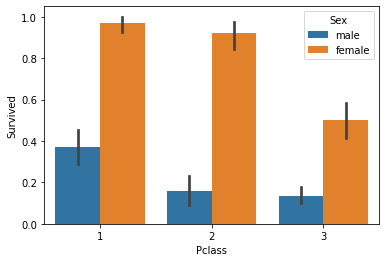

In [450]:
import seaborn as sns

sns.barplot(x="Pclass", y="Survived", hue="Sex", data=train_data)


We can see that our question made sense. Regardless of the class, the most important thing was gender. We can see however that men had a higher chance of survival if they bought class 1 tickets. This shows that both Sex and the class are good features affecting the survival chance.
* Survival females class 1: 96.8%
* Survival females class 2: 92.1%
* Survival females class 3: 50%
* Survival males class 1: 36.8% (even the highest survival rate based on class for men si still lower that the lowest survival rate of women)

## Did a passengers age influence the chance of survival?

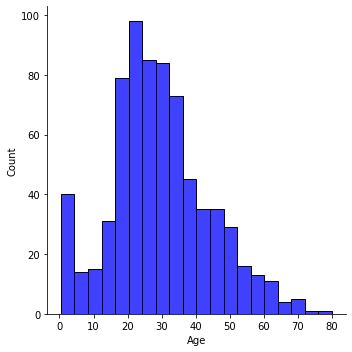

In [451]:
sns.displot(train_data["Age"], color='b', bins=20)


It's a pretty normal Gaussian distribution. Let's plot survivors and deaths based on age.

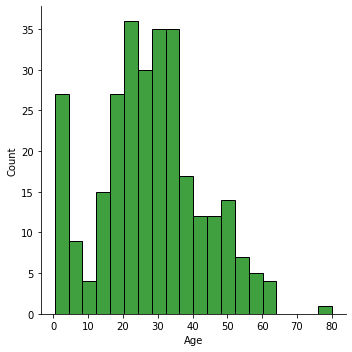

In [452]:
sns.displot(train_data[train_data["Survived"] == 1]["Age"], color='g', bins=20)

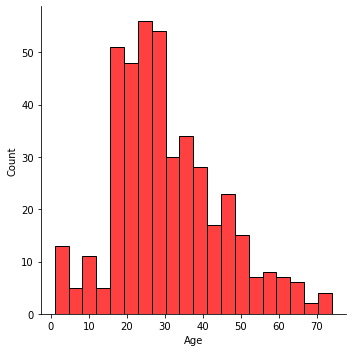

In [453]:
sns.displot(train_data[train_data["Survived"] == 0]["Age"], color='r', bins=20)

Not very visible. Let's put then on top of each other.

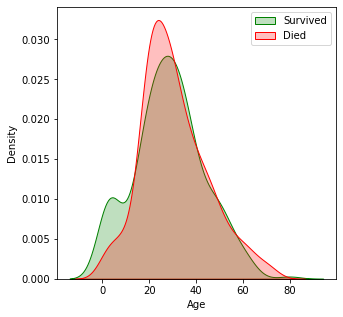

In [454]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.kdeplot(train_data[train_data["Survived"] == 1]["Age"], shade=True, ax=ax, label="Survived", color='g')
sns.kdeplot(train_data[train_data["Survived"] == 0]["Age"], shade=True, ax=ax, label="Died", color='r')
plt.legend()


We didn't learn a lot by looking at this except the fact that seems to be a raise in survivors at a very small age. We should try and investigate the age and the sex together because it makes sense that age SHOULD HAVE an influence on survival:

<AxesSubplot:xlabel='Age', ylabel='Sex'>

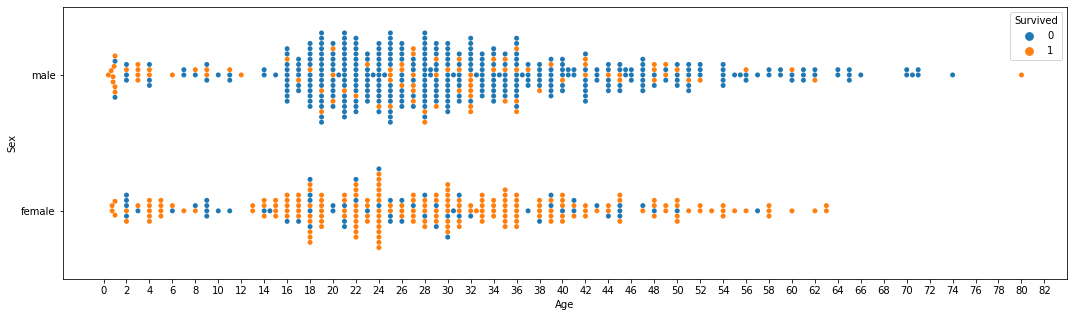

In [455]:
fix, ax = plt.subplots(figsize=(18, 5))
plt.xticks(list(range(0, 100, 2)))
sns.swarmplot(x="Age", y="Sex", hue="Survived", data=train_data)


This view gives us a bit more information that before. We can see that a big portion of the male survivors are between 0-12 years old. Alsom the oldest passenger, an 80 year old survived.

Let's also check the survival rate between age and class:

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

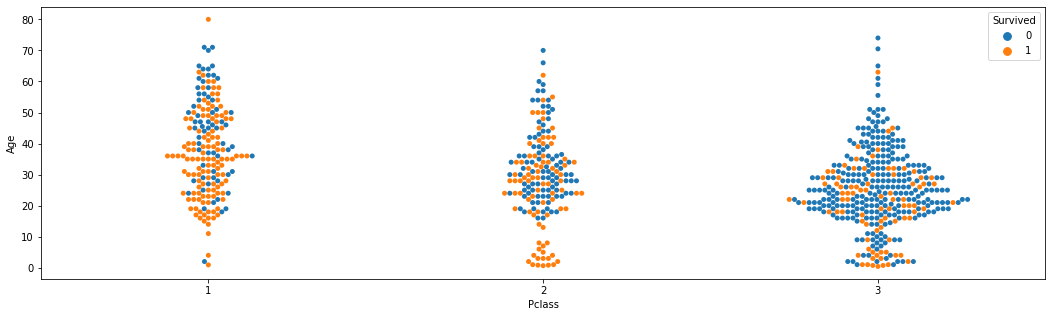

In [456]:
fix, ax = plt.subplots(figsize=(18, 5))
sns.swarmplot(x="Pclass", y="Age", hue="Survived", data=train_data)


As expected a lot of survivors in class 1. It's also interesting to see that there were not a lot of children inb class 1. Maybe rich people don't make a lot of kids?

## Did paying the ticket price influence the chance of survival?

In [457]:
train_data["Fare"].describe()


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

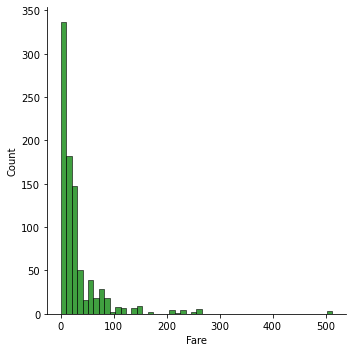

In [458]:
sns.displot(train_data["Fare"], color='g', bins=50)


It's not a normal distribution and it has a huge spike between 0-100. 75% of the people paid under 31$ and the most pricey ticket was 512$.
Maybe we should scale this feature depending on the model.

As befor we should check the correlation between the survival and the fares but the problem is we have too many different values for the Fares. A way of approaching this is to group the fares into categories to visualize them better. The way we decide these categories are looking at the distribution above. This process of cateogrizing numerical features is called binning. We could actually use this new cateogry when training the model. We're not sure it will help but we can check with it and without it.

<AxesSubplot:xlabel='Fare', ylabel='Survived'>

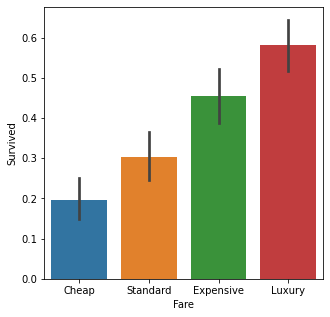

In [459]:
fig, ax = plt.subplots(figsize=(5, 5))
fare_categories = pd.qcut(train_data["Fare"], 4, labels=['Cheap', 'Standard', 'Expensive',
                                                         'Luxury'])  # This splits it based on %: 0 0.25 0.5 0.75 1
sns.barplot(x=fare_categories, y=train_data["Survived"], ax=ax)


It's pretty clear to see that chances of survivability clearly go up with the Fare price.
* Cheap (0-25% of max price) Survival Rate 0.2
* Standard (25-50% of max price) Survival Rate 0.3
* Expensive (50-75% of max price) Survival Rate 0.45
* Luxury (75-100% of max price) Survival Rate 0.55

We can also check the relationship between the fare, sex and survival rate to understand more about the importance of the fare:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Sex', ylabel='Fare'>

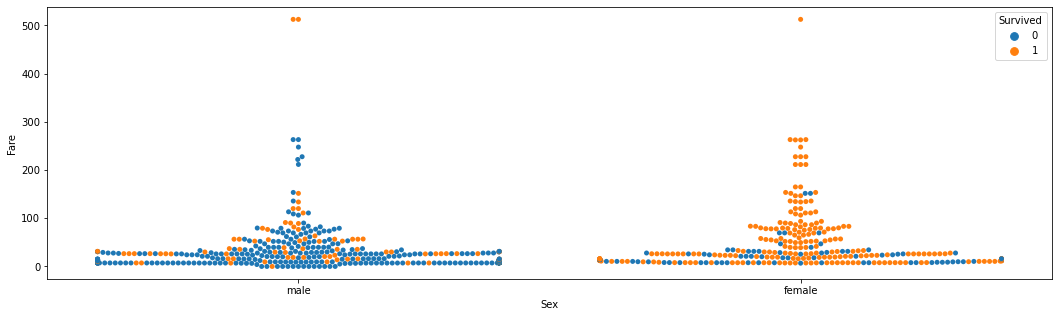

In [460]:
fix, ax = plt.subplots(figsize=(18, 5))
sns.swarmplot(x="Sex", y="Fare", hue="Survived", data=train_data)


We can see some more things with this. All people, no matter the sex with tickets above 500 survived.
All male passengers between 200-300 died but all women between 200-300 survived. Interesting.
All of these are patterns that a classifier can see.

Another thing we can see in the describe is that the smallest Fare paid was 0.0 .This does not seem right. Let's check out who these people were:

In [461]:
train_data.loc[train_data["Fare"] == 0]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Not a lot of info except maybe the fact that they were all men, they all embarked at Southampton and all except 1 of them died.
Maybe they didnt pay because they were reporters, family members of the crew or something else.

Besides these, since it doesn't make sense for Fare prices to be 0 we will replace them with NaN and we will fill them with the imputed using the median later when we feature engineer:

In [462]:
train_data.loc[train_data["Fare"] == 0, "Fare"] = np.NaN
test_data.loc[train_data["Fare"] == 0, "Fare"] = np.NaN

## Could the place of embarkation influence the chance of survival?
Logic would tell us that the embarkation place should not matter at all but we should investigate it and not make assumptions about the data.
We count count how many embarkations we has at each location and plot them:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Embarked', ylabel='count'>

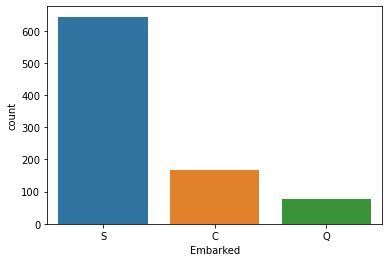

In [463]:
sns.countplot(train_data["Embarked"])


In [464]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [465]:
train_data.groupby("Embarked")["Survived"].value_counts(normalize=True)

Embarked  Survived
C         1           0.553571
          0           0.446429
Q         0           0.610390
          1           0.389610
S         0           0.663043
          1           0.336957
Name: Survived, dtype: float64

We can also plot it against survival rate to see any connections there:

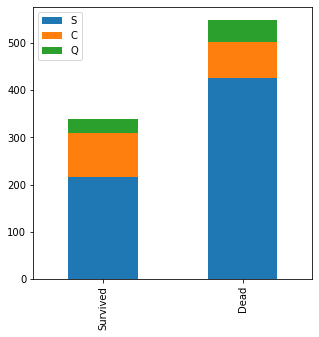

In [466]:
survival_chart_stacked(train_data, "Embarked")

<AxesSubplot:xlabel='Embarked', ylabel='count'>

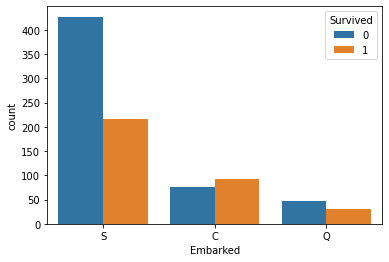

In [467]:
sns.countplot(x="Embarked", hue="Survived", data=train_data)


We can see that most of the passengers embarked at Southampton. However, only 33% survived. The passengers from Cherbourg have the highest survival rate of 55%.
It's always important to not make prios assumptions we should use common sense all the time.Why should the place of embarkation influence the survival rate? Why is the likelihood higher at Cherbourg.

## Was the high number of survivors that embarked at Cherbourg due to a high number of Class 1 passengers?
We know the class increases the chance of survival so let's check if there's more class 1 passengers at Cherbourg vs the rest.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

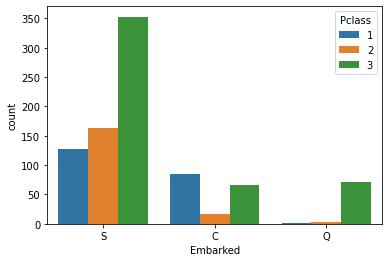

In [468]:
sns.countplot(x="Embarked", hue="Pclass", data=train_data)


In [469]:
train_data.groupby(["Embarked", "Pclass"])["Survived"].sum()


Embarked  Pclass
C         1         59
          2          9
          3         25
Q         1          1
          2          2
          3         27
S         1         74
          2         76
          3         67
Name: Survived, dtype: int64

Hey, our assumption was correct it seems. The majority of people that embarked at Cherbourg were class 1.
In contrast, the majority that embarked at Southampton were class 3.

Even so, going back to the survival percentages it's not clear why the survival rate for Queenstown is slightly higher (38.9% > 33%) than Southampton even though the number of class 1 passengers in relation to class 3 passengers is higher for Southampton.
Maybe the difference is in the ration of males vs females.

## Is gender distribution responsible for the slightly higher passenger survival rate in Queenstown compared to Southampton?

<AxesSubplot:xlabel='Embarked', ylabel='count'>

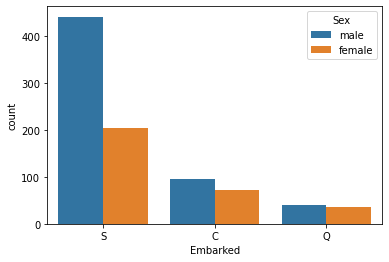

In [470]:
sns.countplot(x="Embarked", hue="Sex", data=train_data)


Yea, this confirms what we thought... More than twice as many men embarked at Southampton than women as opposed to Queenstown where it's roughly the same number of men and women. It shown again how much the gender matters for survival.

## Does the number of children/siblings/spouses or parents on board influence the chance of survival?

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

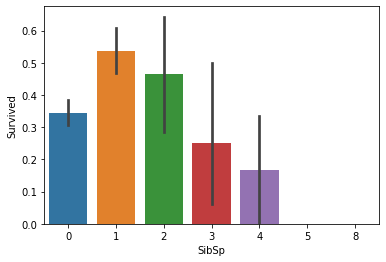

In [471]:
sns.barplot(x="SibSp", y="Survived", data=train_data)


<AxesSubplot:xlabel='SibSp', ylabel='count'>

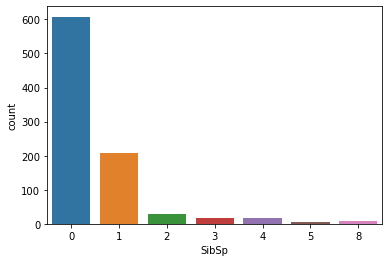

In [472]:
sns.countplot(x="SibSp", data=train_data)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

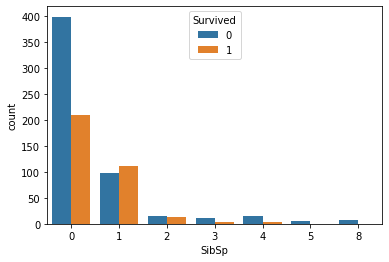

In [473]:
sns.countplot(x="SibSp", hue="Survived", data=train_data)


In [474]:
train_data.groupby("SibSp")["Survived"].value_counts(normalize=True)

SibSp  Survived
0      0           0.654605
       1           0.345395
1      1           0.535885
       0           0.464115
2      0           0.535714
       1           0.464286
3      0           0.750000
       1           0.250000
4      0           0.833333
       1           0.166667
5      0           1.000000
8      0           1.000000
Name: Survived, dtype: float64

We can see that the majority of the passenges travelled alone. Also, looking at the last graph we can also deduce that the more siblings a passenger had the smaller the chance of survival. It's worth noting that we can see an increase in survival chance if a passenger had 1 or 2 siblings but it falls fast for anything higher.

Let's also check the parents and children which is in the Parch feature:

<AxesSubplot:xlabel='Parch', ylabel='count'>

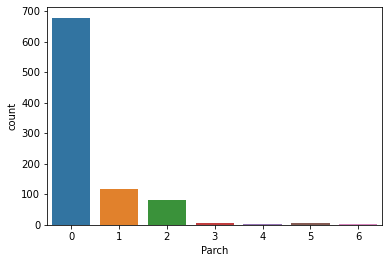

In [475]:
sns.countplot(x="Parch", data=train_data)


<AxesSubplot:xlabel='Parch', ylabel='Survived'>

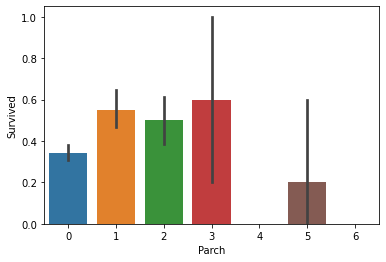

In [476]:
sns.barplot(x="Parch", y="Survived", data=train_data)


<AxesSubplot:xlabel='Parch', ylabel='count'>

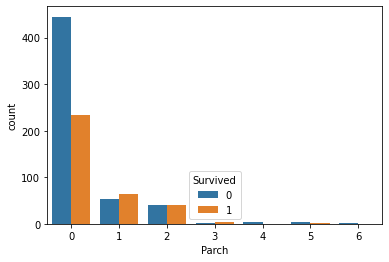

In [477]:
sns.countplot(x="Parch", hue="Survived", data=train_data)


In [478]:
train_data.groupby("Parch")["Survived"].value_counts(normalize=True)

Parch  Survived
0      0           0.656342
       1           0.343658
1      1           0.550847
       0           0.449153
2      0           0.500000
       1           0.500000
3      1           0.600000
       0           0.400000
4      0           1.000000
5      0           0.800000
       1           0.200000
6      0           1.000000
Name: Survived, dtype: float64

We see the same thing here as we saw with the siblings. We can see that small families (2-4 members) had a higher chance of survival than large families or people who travelled alone.

We learned a lot about the data. Let's get to some feature engineering to see what we can improve.

# Feature Engineering
## Adding a Title feature
Let's look at the name feature because we avoided it until now. In theory a person's name should not have any importance related to survivability but let's look at the values

In [479]:
train_data['Name']


0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

It seems that a title can be present in the name, we see that for most of them actually. How about we turn that into a feature that might be useful. Keeping the names as cateogrical values does not make any sense though. Let's make a piece of code that extracts the title from a string.

In [480]:
train_data['Title'] = train_data['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

In [481]:
train_data['Title'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Title
Non-Null Count  Dtype 
--------------  ----- 
891 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


Cool, our code works and there are no null values in the new feature, let's look at its values:

In [482]:
train_data['Title'].value_counts()


Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

Some are outliers. Let's replace them and put outlier male titles in Mr and outlier female titles in Miss

In [483]:
train_data = train_data.replace({
    'Title': {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'the Countess': 'Mrs', 'Don': 'Mr', 'Mme': 'Mrs',
              'Ms': 'Miss', 'Lady': 'Miss', 'Sir': 'Mr', 'Capt': 'Mr', 'Jonkheer': 'Mr'}
})

train_data['Title'].value_counts()


Mr        525
Miss      186
Mrs       127
Master     40
Dr          7
Rev         6
Name: Title, dtype: int64

Looks good. Let's check it's relatability with the Survival Rate:

<AxesSubplot:xlabel='Title', ylabel='count'>

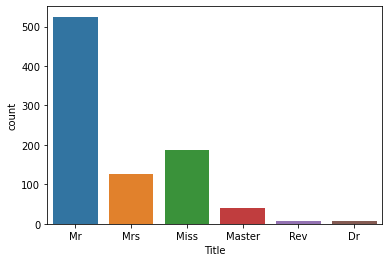

In [484]:
sns.countplot(x="Title", data=train_data)


<AxesSubplot:xlabel='Title', ylabel='Survived'>

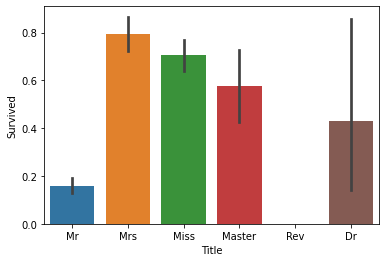

In [485]:
sns.barplot(x="Title", y="Survived", data=train_data)

<AxesSubplot:xlabel='Title', ylabel='count'>

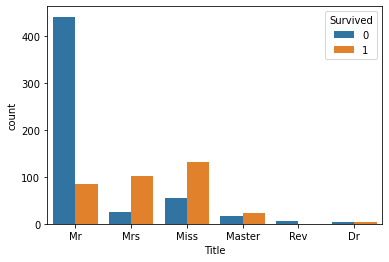

In [486]:
sns.countplot(x="Title", hue='Survived', data=train_data)


This new feature mas potential. We can see that female titles have high survival rates.
Also, Master and Dr titles have a suprisingly high survival rate even though they are male titles.
Being a Mr however has a small survival rate of 15%.
All of the revenant died. Revenants are corpses that come back to life. No idea why this title is in the set:)). Maybe they finally accepted their fate.

## Cabin and Ticket Features

In [487]:
train_data[['Cabin', 'Ticket']]


,Cabin,Ticket
0,NaN,A/5 21171
1,C85,PC 17599
2,NaN,STON/O2. 3101282
3,C123,113803
4,NaN,373450
...,...,...
886,NaN,211536
887,B42,112053
888,NaN,W./C. 6607
889,C148,111369


Weird values for both of them... Cabin has a lot of missing values and the ticket values is all over the place.
We can try a few things:
* we can keep the first 2 letters of the ticket
* we can keep the number of chars in the ticket
* we can count the number of cabins used (they're separated by a space in the value)
* we can keep the first letter of the cabin

In [488]:
train_data['Ticket_2letter'] = train_data['Ticket'].apply(lambda ticket: ticket[:2])
train_data['Ticket_len'] = train_data['Ticket'].apply(lambda ticket: len(ticket))

train_data['Cabin_sum'] = train_data[~train_data['Cabin'].isna()]['Cabin'].apply(lambda cabin: len(str(cabin).split()))
train_data['Cabin_1letter'] = train_data[~train_data['Cabin'].isna()]['Cabin'].apply(lambda cabin: str(cabin)[:1])


## Adding a Family Size Feature
We can combine Parch and SibSp can be added together since they behave the similarly

In [491]:
train_data['Family_Size'] = train_data['SibSp'] + train_data['Parch'] + 1  #the 1 is the person. he's part of the family


<AxesSubplot:xlabel='Family_Size', ylabel='Survived'>

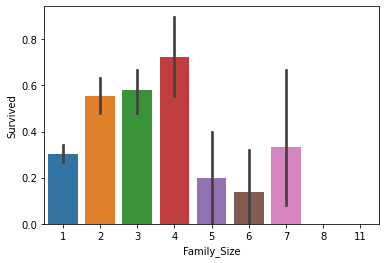

In [492]:
sns.barplot(x="Family_Size", y="Survived", data=train_data)


<AxesSubplot:xlabel='Family_Size', ylabel='count'>

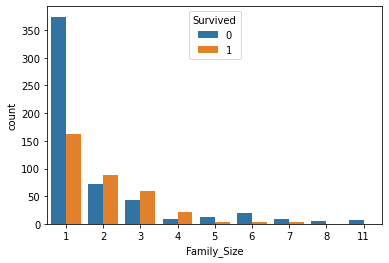

In [493]:
sns.countplot(x="Family_Size", hue='Survived', data=train_data)


We can engineer it even more since we see a pattern introducing a family type by separating into 4 distinct groups

In [494]:
train_data['Family_Type'] = pd.cut(train_data['Family_Size'], [0, 1, 4, 7, 11], labels=['Alone', 'Small', 'Big', 'Very Big'])


<AxesSubplot:xlabel='Family_Type', ylabel='Survived'>

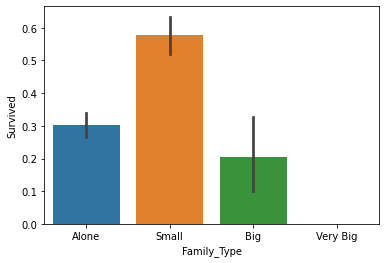

In [495]:
sns.barplot(x="Family_Type", y="Survived", data=train_data)


<AxesSubplot:xlabel='Family_Type', ylabel='count'>

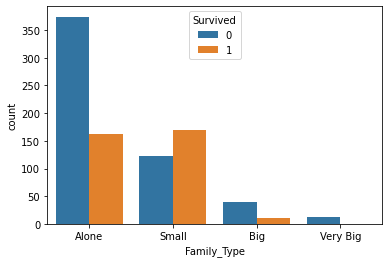

In [496]:
sns.countplot(x="Family_Type", hue='Survived', data=train_data)
